https://github.com/pymc-devs/pymc3/pull/2876

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pylab as plt

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Cherry picked commit

In [2]:
from pymc3.model import modelcontext, get_named_nodes_and_relations
from pymc3.util import is_transformed_name, get_untransformed_name
from tqdm import tqdm


def sample_prior(samples=500, model=None, vars=None, size=None,
                 random_seed=None, progressbar=True):
    """Generate samples from the prior of a model.

    Parameters
    ----------
    samples : int
        Number of samples from the prior to generate. Defaults to 500.
    model : Model (optional if in `with` context)
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.named_vars`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    random_seed : int
        Seed for the random number generator.
    progressbar : bool
        Whether or not to display a progress bar in the command line.

    Returns
    -------
    dict
        Dictionary with the variables as keys. The values are arrays of prior samples.
    """

    model = modelcontext(model)

    if vars is None:
        vars = set(model.named_vars.keys())

    if random_seed is not None:
        np.random.seed(random_seed)

    if progressbar:
        indices = tqdm(range(samples))

    def step(model):
        point = {}
        for var in model.basic_RVs:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=size)
                    var_name_untranf = get_untransformed_name(var_name)
                    point[var_name_untranf] = val
                    val = var.distribution.transform_used.forward_val(val)
                else:
                    val = var.distribution.random(point=point, size=size)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val
        return point

    try:
        prior = {var: [] for var in vars}
        for _ in indices:
            point = step(model)
            for var_name, var in model.named_vars.items():
                if var_name in vars:
                    if var_name in point:
                        val = point[var_name]
                    else:
                        nn, _, _ = get_named_nodes_and_relations(var)
                        val = var.eval({model.named_vars[v]: point[v]
                                        for v in nn})
                    prior[var_name].append(val)

    except KeyboardInterrupt:
        pass

    finally:
        if progressbar:
            indices.close()

    return {k: np.asarray(v) for k, v in prior.items()}

In [3]:
observed = np.random.normal(10, 1, size=200)
with pm.Model() as m: 
    # Use a prior that's way off to show we're actually sampling from it 
    mu = pm.Normal('mu', mu=-10, sd=1) 
    positive_mu = pm.Deterministic('positive_mu', np.abs(mu)) 
    pm.Normal('x_obs', mu=mu, sd=1, observed=observed) 
    prior = sample_prior() 

assert (prior['mu'] < 0).all() 
assert (prior['positive_mu'] > 0).all() 
assert (prior['x_obs'] < 0).all()

100%|██████████| 500/500 [00:00<00:00, 1675.65it/s]


## More complex example

In [4]:
data = pd.read_table(pm.get_data('efron-morris-75-data.tsv'), sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T
N = len(hits)

### Reference numpy implementation

In [5]:
import scipy.stats as stats

In [6]:
def model_prior_sample(nsample):
    phi = stats.beta.rvs(1., 1., size=nsample)
    logkappa = np.random.exponential(1/5., nsample)
    kappa = np.exp(logkappa)
    thetas = stats.beta.rvs(phi*kappa, (1.-phi)*kappa, size=(N, nsample))
    y = stats.binom.rvs(n=at_bats[:, None], p=thetas)
    
    psample = {}
    psample['phi'] = phi
    psample['logkappa'] = logkappa
    psample['kappa'] = kappa
    psample['thetas'] = thetas.T
    psample['y'] = y.T
    return psample

In [7]:
%%time

psample0 = model_prior_sample(10000)

CPU times: user 71.9 ms, sys: 5.43 ms, total: 77.3 ms
Wall time: 77.4 ms


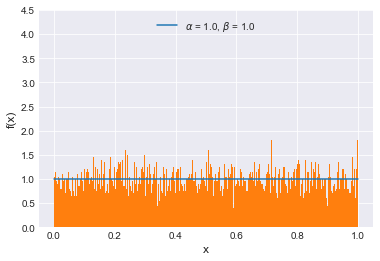

In [8]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample0['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

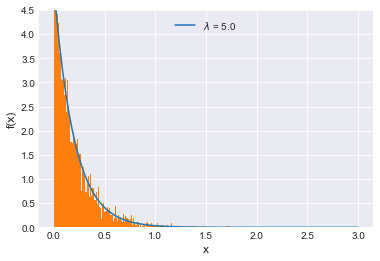

In [9]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample0['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

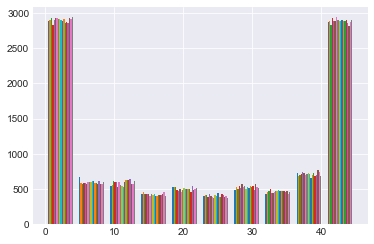

In [10]:
plt.hist(psample0['y']);

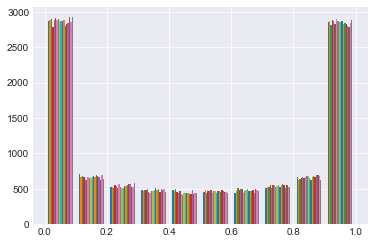

In [11]:
plt.hist(psample0['thetas']);

In [12]:
psample0['thetas'].mean(axis=0) * at_bats

array([22.3365445 , 22.40489738, 22.29671025, 22.72182605, 22.47891939,
       22.46932622, 22.49655555, 22.50779385, 22.52546474, 22.52823201,
       22.38041608, 22.41091891, 22.58897736, 22.48651101, 22.33446269,
       22.3721184 , 22.41926968, 22.33399209])

In [13]:
psample0['y'].mean(axis=0)

array([22.3238, 22.4261, 22.2838, 22.7543, 22.4663, 22.5181, 22.4796,
       22.5051, 22.5321, 22.5051, 22.3974, 22.4052, 22.5952, 22.4954,
       22.3411, 22.3733, 22.4216, 22.3127])

### PyMC3

In [14]:
with pm.Model() as model:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N, observed=hits)

In [15]:
y.distribution.random(point=model.test_point, size=1000)

array([[14,  0,  0, ...,  1, 43, 42],
       [17,  2,  2, ...,  0, 43, 44],
       [19,  4,  0, ...,  0, 44, 42],
       ...,
       [12,  1,  0, ...,  0, 43, 43],
       [16,  0,  0, ...,  0, 43, 43],
       [10,  5,  0, ...,  0, 44, 43]])

In [16]:
np.random.binomial(45, thetas.tag.test_value, size=(1000, N))

array([[13, 22, 23, ..., 23, 29, 21],
       [16, 22, 25, ..., 22, 23, 24],
       [25, 21, 25, ..., 23, 27, 24],
       ...,
       [17, 24, 19, ..., 23, 25, 22],
       [21, 23, 21, ..., 21, 28, 14],
       [25, 19, 24, ..., 25, 20, 24]])

In [17]:
# names = ['phi', 'kappa_log', 'kappa', 'thetas', 'y']
# values = pm.distributions.draw_values([model[name] for name in names], size=100)
# p = {k: v for k, v in zip(names, values)}

In [18]:
%%time
psample1 = sample_prior(10000, model=model)

100%|██████████| 10000/10000 [00:28<00:00, 344.96it/s]


CPU times: user 27.9 s, sys: 593 ms, total: 28.5 s
Wall time: 29.1 s


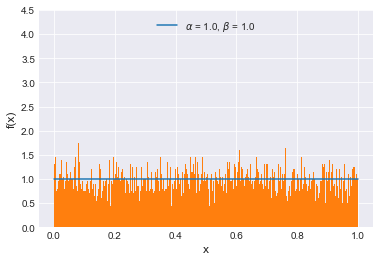

In [19]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample1['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

In [20]:
np.min(psample1['phi']), np.max(psample1['phi'])

(0.00018182519007093234, 0.9998991728887229)

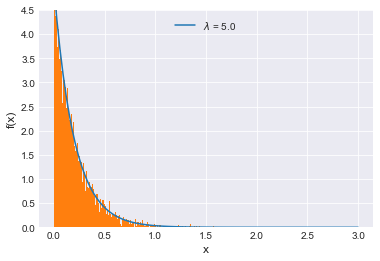

In [21]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample1['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

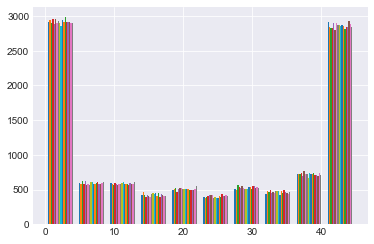

In [22]:
plt.hist(psample1['y']);

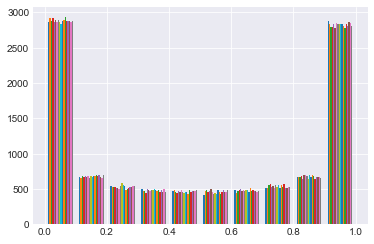

In [23]:
plt.hist(psample1['thetas']);

In [24]:
psample1['thetas'].mean(axis=0) * at_bats

array([22.4562556 , 22.32017225, 22.3463139 , 22.36098063, 22.42782094,
       22.30720201, 22.51184482, 22.42915697, 22.32454652, 22.48766166,
       22.33012049, 22.43088119, 22.13485788, 22.41605156, 22.30553331,
       22.44427576, 22.45231589, 22.26498444])

In [25]:
psample1['y'].mean(axis=0)

array([22.4472, 22.3137, 22.3577, 22.3489, 22.42  , 22.3147, 22.5089,
       22.4233, 22.3257, 22.4764, 22.3132, 22.4591, 22.1321, 22.419 ,
       22.319 , 22.4562, 22.4475, 22.3041])

In [13]:
with pm.Model() as model_:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N)

In [27]:
%%time
with model_:
    psample2 = pm.sample(10000, tune=5000, chains=1, step=pm.Metropolis())

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [y]
>Metropolis: [thetas_logodds__]
>Metropolis: [logkappa_log__]
>Metropolis: [phi_logodds__]
100%|██████████| 15000/15000 [00:14<00:00, 1006.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 17.5 s, sys: 402 ms, total: 17.9 s
Wall time: 17.8 s


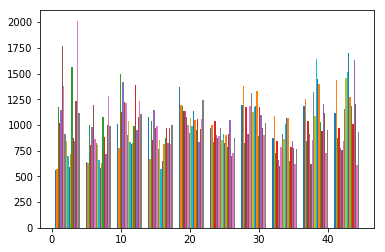

In [28]:
plt.hist(psample2['y']);

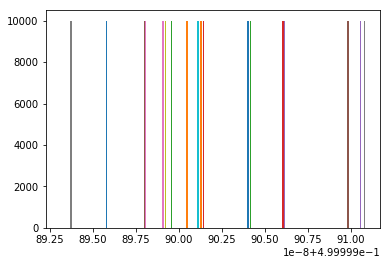

In [29]:
plt.hist(psample2['thetas']);

In [11]:
psample1['thetas'].mean(axis=0) * at_bats

array([29.17537646, 29.19002776, 29.15011068, 29.14314161, 29.14502391,
       29.16139058, 29.1881896 , 29.17654139, 29.19103725, 29.18007975,
       29.16310776, 29.13774703, 29.19948359, 29.15999634, 29.18637443,
       29.19694937, 29.16231964, 29.17803222])

In [12]:
psample1['y'].mean(axis=0)

array([27.9016, 27.851 , 27.989 , 27.8241, 27.801 , 28.0052, 27.8268,
       28.0808, 27.9234, 27.8336, 28.078 , 27.8091, 27.8389, 28.0057,
       27.9665, 27.8917, 27.9447, 27.8897])

##  Wrap in function 

In [35]:
from pymc3.step_methods.arraystep import BlockedStep
from pymc3.blocking import ArrayOrdering, DictToArrayBijection

class PriorStep(BlockedStep):
    """
    Blocked step method that is generalized to accept vectors of variables.

    Parameters
    ----------
    vars : list
        List of variables for sampler.
    model : PyMC Model
        Optional model for sampling step. Defaults to None (taken from context).
    allvars: Boolean (default True)
    blocked: Boolean (default True)
    """

    def __init__(self, vars=None, model=None, allvars=True, blocked=True):
        model = pm.modelcontext(model)

        if vars is None:
            vars = model.basic_RVs

        self.vars = vars
        self.model = model
        self.allvars = allvars
        self.blocked = blocked

    def step(self, point):
        model = self.model
        point = {}
        for var in self.vars:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=None)
                else:
                    val = var.distribution.random(point=point, size=None)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val

        for var_name, var in model.named_vars.items():
            if not var_name in point:

                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})
            point[var_name] = val
        return point

In [37]:
with model:
    step = PriorStep()

In [38]:
step.step(model.test_point)

TypeError: Bad input argument to theano function with name "<ipython-input-17-a594ea16b4a0>:72" at index 0 (0-based). Wrong number of dimensions: expected 1, got 0 with shape ().

In [ ]:
names = pm.util.get_default_varnames(model.named_vars, include_transformed=False)
names